# Analysis of German Travel Behavior

**Data Source & Notebook Description**

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from dotenv import load_dotenv
import sql_functions as sf

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#plot Style
sns.set_style("whitegrid")
sns.set_palette('tab10')

### Data Loading from postgres

In [2]:
# enter the schema name for your course
# schema = 'capstone_travel_index'

# ger_dest_country = sf.get_dataframe(f'SELECT * FROM {schema}.german_dest_country')
# ger_dest_continent = sf.get_dataframe(f'SELECT * FROM {schema}.german_dest_continent')
# ger_in_out = sf.get_dataframe(f'SELECT * FROM {schema}.german_in_out')
# ger_trans = sf.get_dataframe(f'SELECT * FROM {schema}.german_transport')
# df_env = sf.get_dataframe(f'SELECT * FROM {schema}.df_env_scr')
# df_gov = sf.get_dataframe(f'SELECT * FROM {schema}.df_gov_scr')
# df_soc = sf.get_dataframe(f'SELECT * FROM {schema}.df_soc_scr')
# df_lgb = sf.get_dataframe(f'SELECT * FROM {schema}.df_lgb_scr')
# df_price = sf.get_dataframe(f'SELECT * FROM {schema}.city_prices_final')

In [ ]:
ger_dest_country = pd.read_csv('data/german_dest_country.csv', encoding='latin1')
ger_dest_continent = pd.read_csv('data/german_dest_continent.csv', encoding='latin1')
ger_in_out = pd.read_csv('data/german_in_out.csv', encoding='latin1')
ger_trans = pd.read_csv('data/german_transport.csv', encoding='latin1')
df_env = sf.get_dataframe(f'SELECT * FROM {schema}.df_env_scr')
df_gov = sf.get_dataframe(f'SELECT * FROM {schema}.df_gov_scr')
df_soc = sf.get_dataframe(f'SELECT * FROM {schema}.df_soc_scr')
df_lgb = sf.get_dataframe(f'SELECT * FROM {schema}.df_lgb_scr')
df_price = sf.get_dataframe(f'SELECT * FROM {schema}.city_prices_final')

### Description of the data set and variables

In [3]:
print(df_env.info())
print(df_gov.info())
print(df_soc.info())
print(df_lgb.info())
print(df_price.info())
print(ger_dest_country.info())
print(ger_dest_continent.info())
print(ger_in_out.info())
print(ger_trans.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   env_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   iso3       1930 non-null   object        
 1   year       1930 non-null   datetime64[ns]
 2   gov_score  1930 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------

### Create Dataframe with the average Prices for each country

In [4]:
df_price.head()

,city,iso3,1,3,4,7,13,18,26,108,114
0,Aachen,DEU,10.000000,9.000000,3.500000,2.225000,0.496250,2.950000,72.800630,5.850000,2.885714
1,Aalborg,DNK,17.457899,13.160570,6.647431,2.366888,1.692073,3.222997,94.279686,6.647431,4.521148
2,Aberdeen,GBR,17.419919,6.613763,4.238847,1.177918,1.010355,3.483984,83.189090,4.773058,3.440434
3,Abidjan,CIV,3.048981,8.384696,1.410153,0.727598,0.662391,0.609796,63.695462,4.573471,2.429656
4,Accra,GHA,3.211588,5.821003,0.802897,0.228517,0.418653,0.433564,88.335173,2.925540,1.962515


In [5]:
df_price['price_total'] = df_price.iloc[:, 2:].sum(axis=1)
df_price

,city,iso3,1,3,4,7,13,18,26,108,114,price_total
0,Aachen,DEU,10.000000,9.000000,3.500000,2.225000,0.496250,2.950000,72.800630,5.850000,2.885714,109.707594
1,Aalborg,DNK,17.457899,13.160570,6.647431,2.366888,1.692073,3.222997,94.279686,6.647431,4.521148,149.996122
2,Aberdeen,GBR,17.419919,6.613763,4.238847,1.177918,1.010355,3.483984,83.189090,4.773058,3.440434,125.347369
3,Abidjan,CIV,3.048981,8.384696,1.410153,0.727598,0.662391,0.609796,63.695462,4.573471,2.429656,85.542204
4,Accra,GHA,3.211588,5.821003,0.802897,0.228517,0.418653,0.433564,88.335173,2.925540,1.962515,104.139451
...,...,...,...,...,...,...,...,...,...,...,...,...
531,Zadar,HRV,7.995606,6.647361,2.643390,1.855413,0.941075,1.595367,55.076038,3.212657,1.691879,81.658785
532,Zagreb,HRV,10.606940,7.296962,2.659200,1.737198,1.021138,0.566386,78.444354,2.388272,1.976139,106.696587
533,Zaragoza (Saragossa),ESP,12.000000,7.500000,2.500000,1.471429,0.541250,1.400000,81.852083,2.460000,1.657143,111.381905
534,Zurich,CHE,25.593398,16.379775,8.189887,4.582704,1.333868,4.504438,205.515607,15.356039,5.598556,287.054272


**Calculate the Average price for each country**

In [6]:
df_price_un = pd.DataFrame(df_price.groupby('iso3')['price_total'].mean().reset_index())
df_price_un

,iso3,price_total
0,ALB,87.578086
1,ARE,164.692212
2,ARG,75.313050
3,ARM,150.688130
4,AUS,247.235734
...,...,...
124,VEN,66.123340
125,VNM,59.767783
126,XKX,59.461667
127,ZAF,92.194622


### Create Datafram with all the scores and travel data

In [7]:
df_analysis = pd.merge(ger_dest_country, df_env, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_gov, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_soc, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_lgb, on=['iso3', 'year'], how='left')
df_analysis = pd.merge(df_analysis, df_price_un, on=['iso3'], how='left')


In [8]:
df_analysis.head()

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948


In [9]:
# Select specific years
sel_years = ['2012-01-01', 
             '2013-01-01', 
             '2014-01-01', 
             '2015-01-01', 
             '2016-01-01', 
             '2017-01-01', 
             '2018-01-01', 
             '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis = df_analysis[df_analysis['year'].isin(sel_years)]

### Data Cleaning & Feature Engineering

In [10]:
#Calculate the Total Score and append to the DataFrame
df_analysis['total_score'] = ((df_analysis['env_score'] 
                            + df_analysis['gov_score'] 
                            + df_analysis['soc_score']
                            + df_analysis['lgb_score']) / 4)

In [11]:
#Delete the row with totals in the DataFrame
index_total = df_analysis[df_analysis['iso3'] == 'total'].index
df_analysis = df_analysis.drop(index_total)

In [12]:
df_analysis

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total,total_score
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360,8.393951
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051,9.030803
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560,7.878286
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042,6.442761
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948,6.897282
...,...,...,...,...,...,...,...,...,...
174,CZE,2019-01-01,2728299.0,7.306397,7.770563,8.087819,8.000000,109.638014,7.791195
175,TUR,2019-01-01,3205210.0,5.538721,4.415584,7.705382,4.400000,50.562389,5.514922
176,HUN,2019-01-01,1385049.0,6.582492,6.872294,7.733711,6.400000,81.339403,6.897124
177,GBR,2019-01-01,2981999.0,8.686869,9.004329,8.441926,9.600000,179.763124,8.933281


In [13]:
df_analysis

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total,total_score
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360,8.393951
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051,9.030803
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560,7.878286
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042,6.442761
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948,6.897282
...,...,...,...,...,...,...,...,...,...
174,CZE,2019-01-01,2728299.0,7.306397,7.770563,8.087819,8.000000,109.638014,7.791195
175,TUR,2019-01-01,3205210.0,5.538721,4.415584,7.705382,4.400000,50.562389,5.514922
176,HUN,2019-01-01,1385049.0,6.582492,6.872294,7.733711,6.400000,81.339403,6.897124
177,GBR,2019-01-01,2981999.0,8.686869,9.004329,8.441926,9.600000,179.763124,8.933281


## EDA

### Vacation at home or abroad 

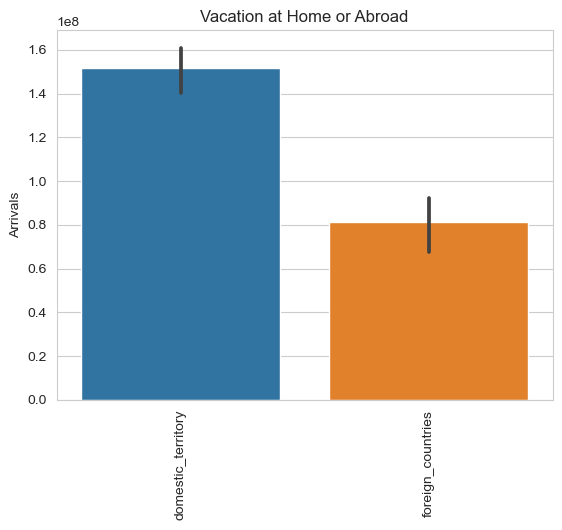

In [14]:
# Plot the bar plot using seaborn
ax = sns.barplot(data=ger_in_out)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Arrivals')
plt.title('Vacation at Home or Abroad')

plt.xticks(rotation=90)

# Display the plot
plt.show()

### Destination Continent

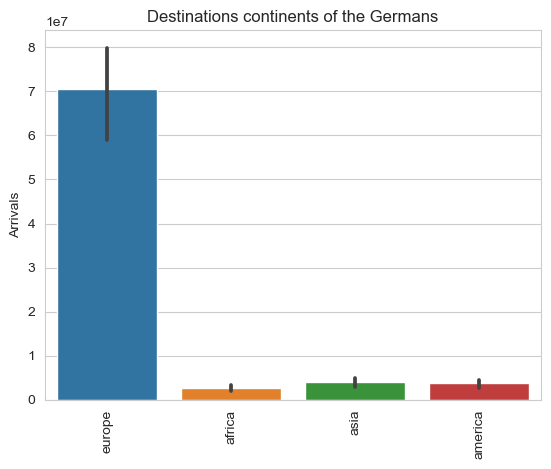

In [15]:
# Plot the bar plot using seaborn
sns.barplot(data=ger_dest_continent)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Arrivals')
plt.title('Destinations continents of the Germans')

plt.xticks(rotation=90)

# Display the plot
plt.show()

### Destinations Country

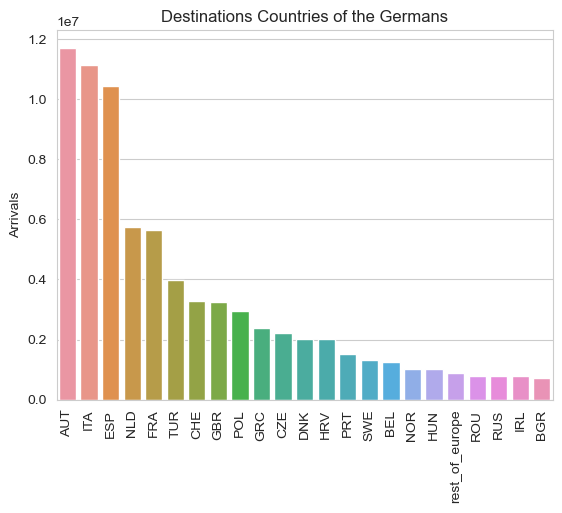

In [16]:
# Group the data by 'sub-region_name' and calculate the sum of 'total'
ger_dest = df_analysis.groupby('iso3')['tourists'].mean().sort_values(ascending=False)

# Reset the index to include 'sub-region_name' as a column
ger_dest = ger_dest.reset_index()

# Plot the bar plot using seaborn
sns.barplot(x='iso3', y='tourists', data=ger_dest)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Arrivals')
plt.title('Destinations Countries of the Germans')

plt.xticks(rotation=90)

# Display the plot
plt.show()

### Mean of Transport

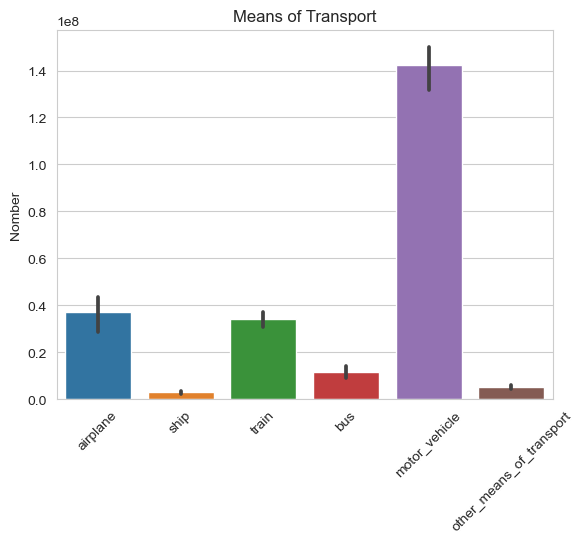

In [17]:
# Plot the bar plot using seaborn
ax = sns.barplot(data=ger_trans)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Nomber')
plt.title('Means of Transport')

plt.xticks(rotation=45)

# Display the plot
plt.show()

In [18]:
ger_trans.columns

Index(['year', 'airplane', 'ship', 'train', 'bus', 'motor_vehicle',
       'other_means_of_transport'],
      dtype='object')

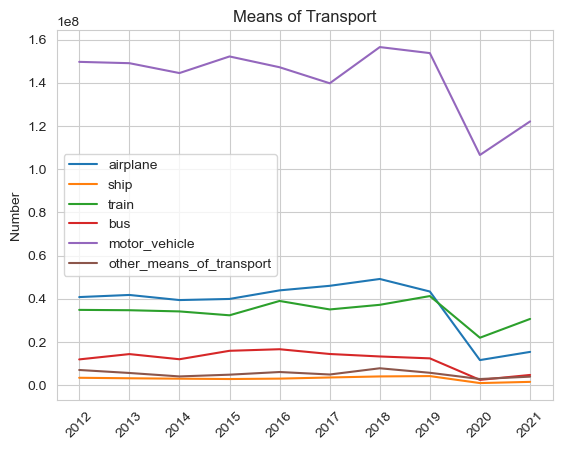

In [19]:
list_trans = ['airplane', 'ship', 'train', 'bus', 'motor_vehicle', 'other_means_of_transport']

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the bar plot using seaborn
for i in list_trans:
    sns.lineplot(data=ger_trans, x='year', y=i, label=i)

# Add labels and title to the plot
plt.xlabel('')
plt.ylabel('Number')
plt.title('Means of Transport')

plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.show()

### Distribution of the numeric Variables

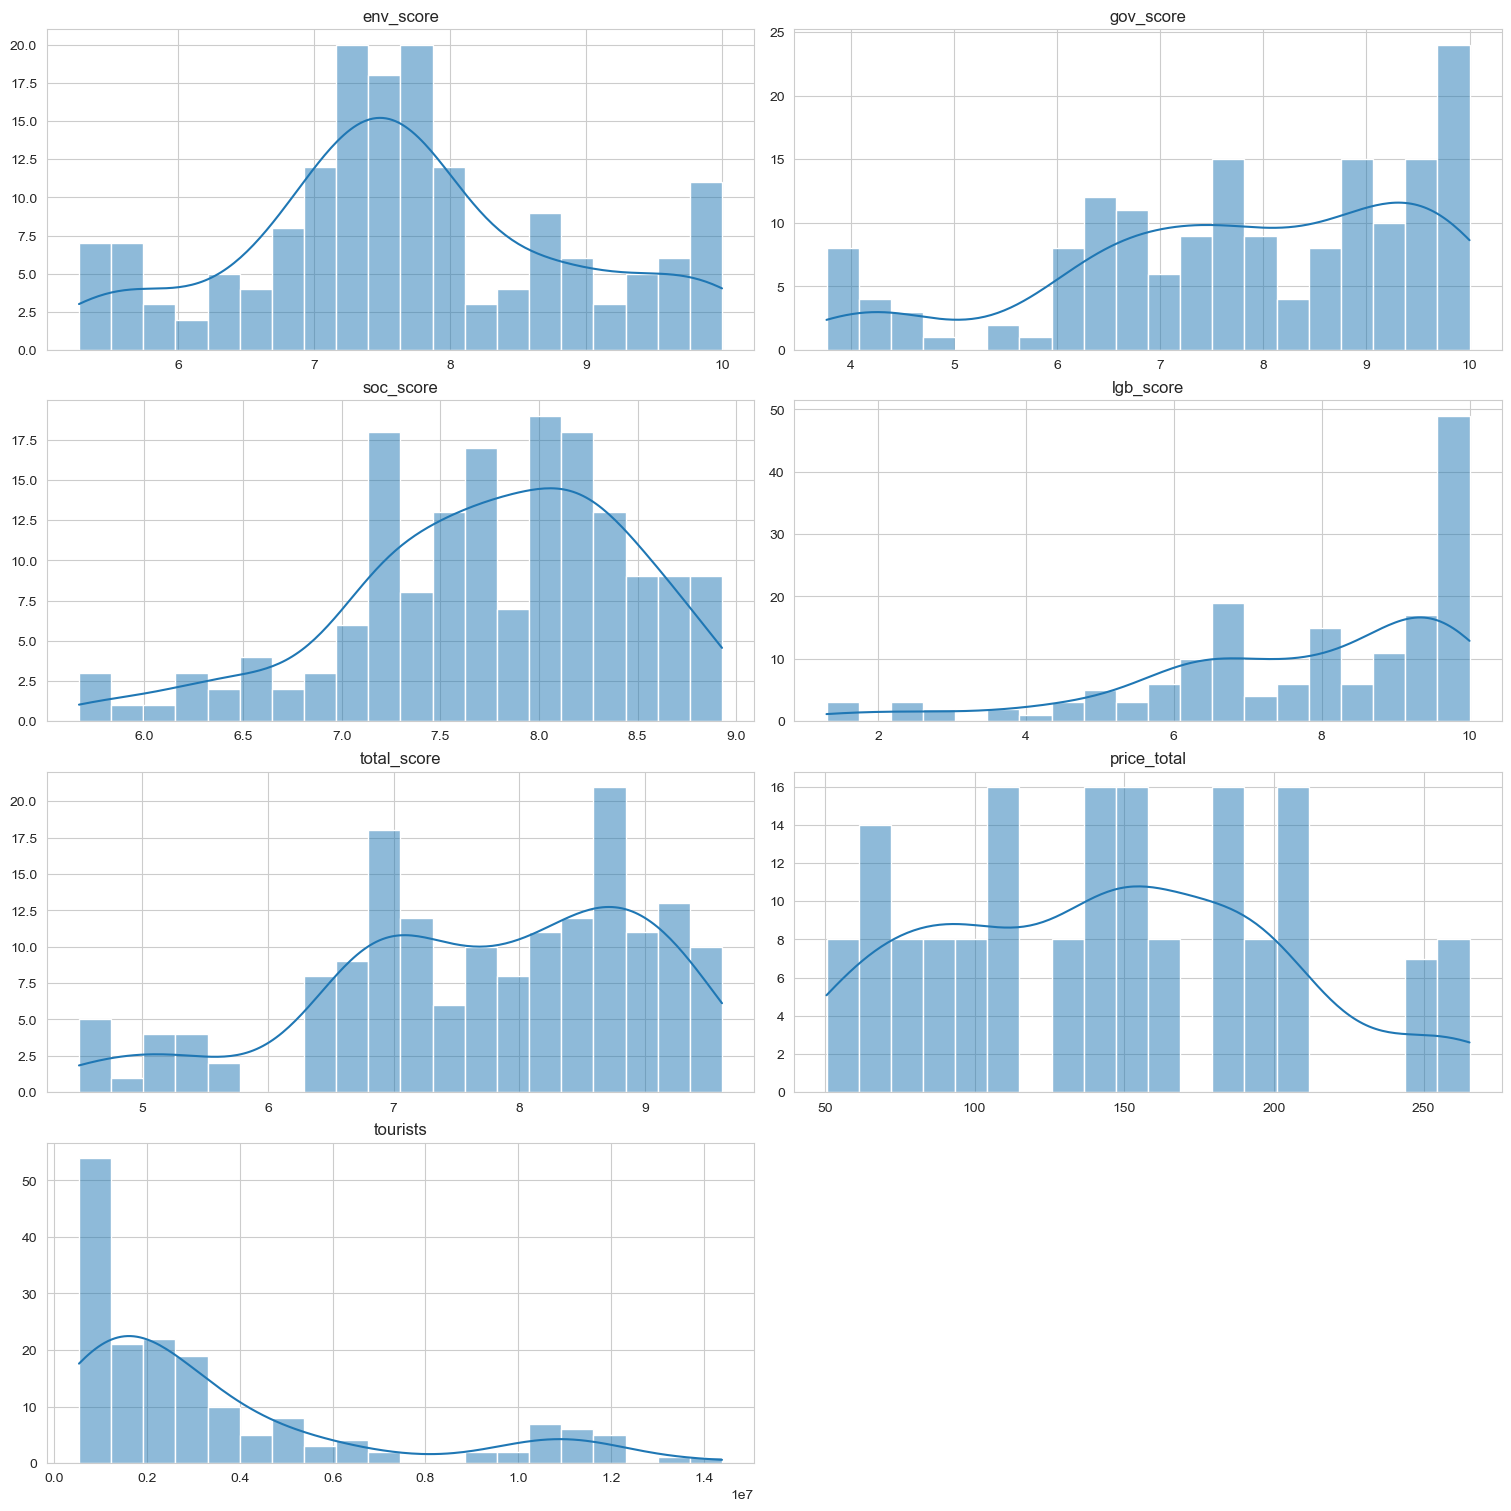

In [20]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score', 'price_total', 'tourists']
rows, cols = 4, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_analysis, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

**Transformation of the strong skewed data**

In [21]:
# # Apply logarithmic transformation to the travel data
df_log = df_analysis.copy()
colum_to_log = ['tourists']
df_log[colum_to_log] = df_log[colum_to_log].apply(lambda x: np.log(x))

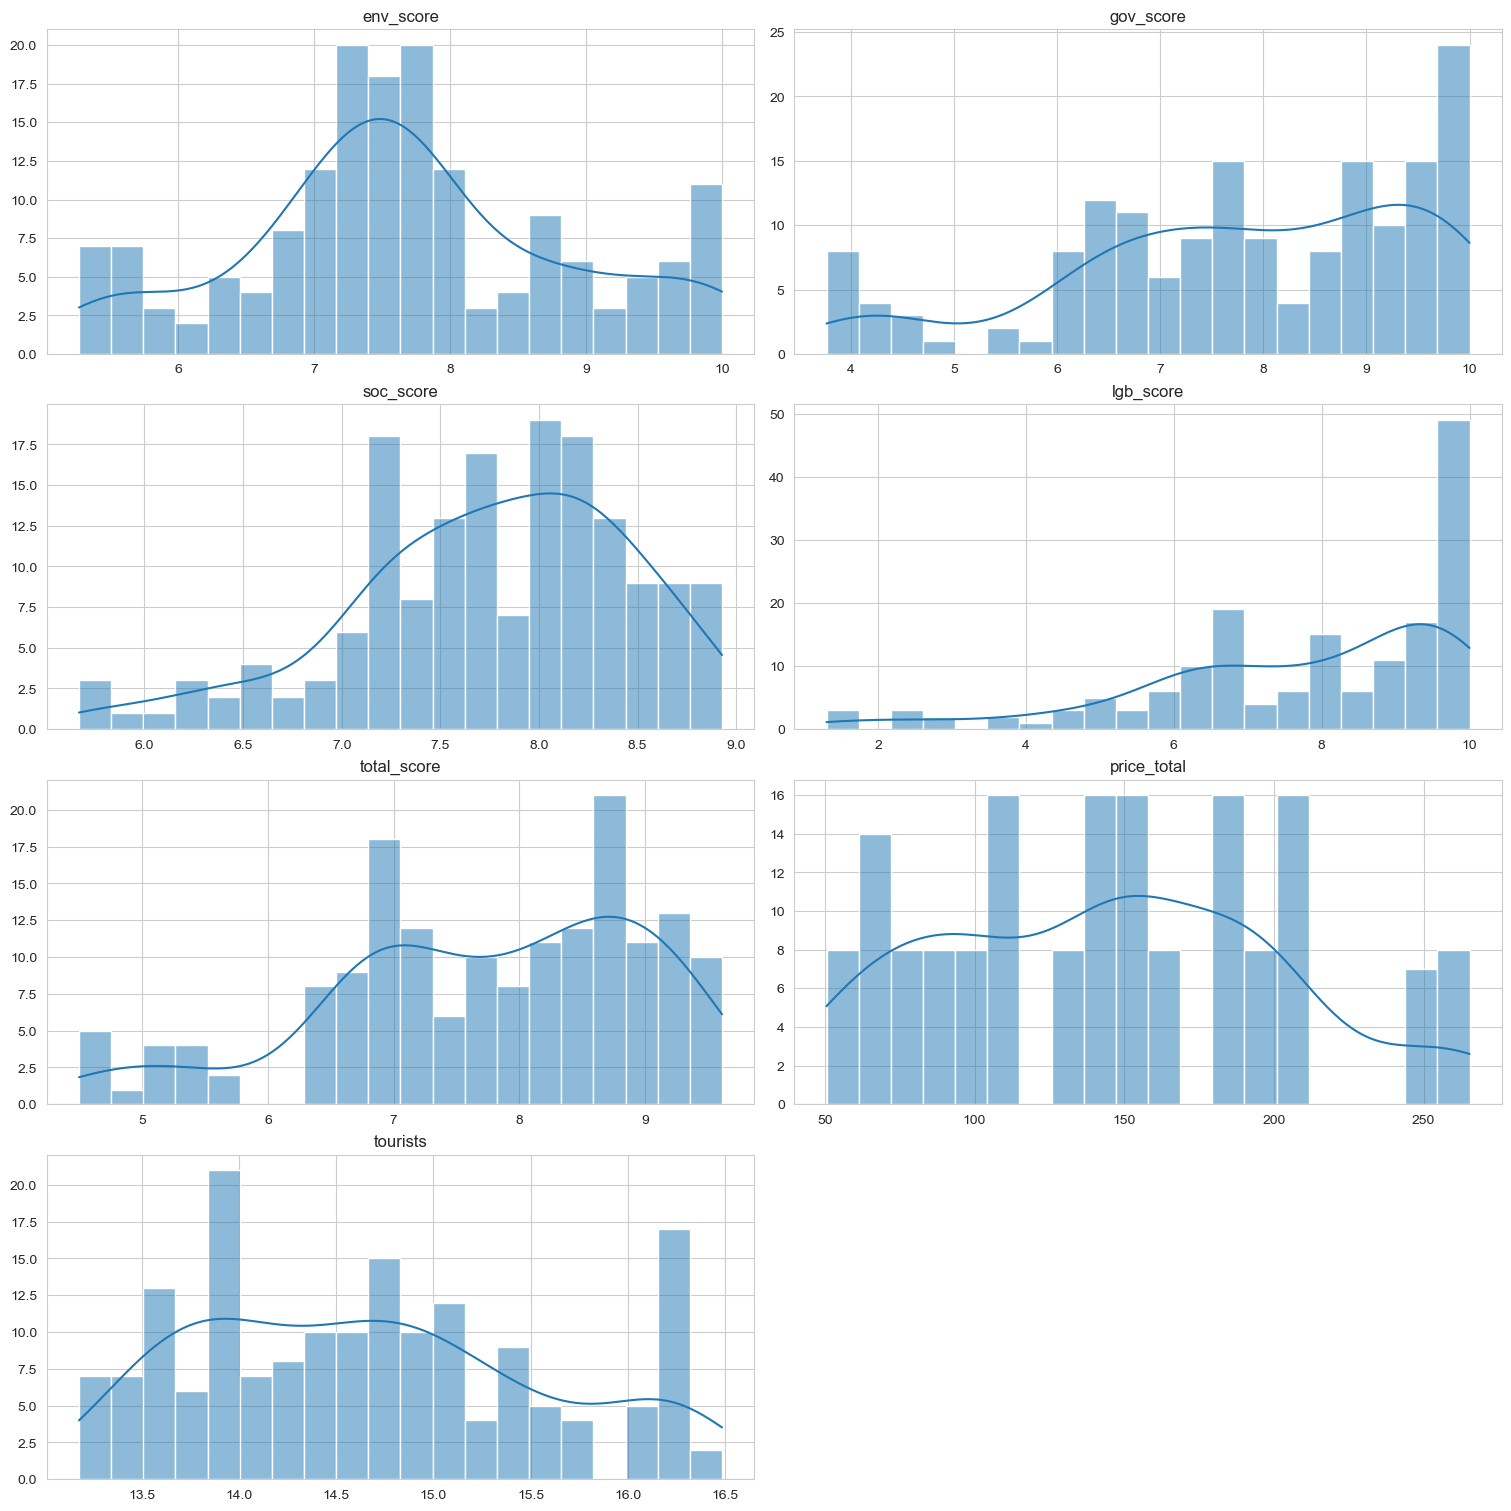

In [22]:
num_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'total_score','price_total', 'tourists']
rows, cols = 4, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data = df_log, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

### Analysis the relations by Pair- and Scatterplot

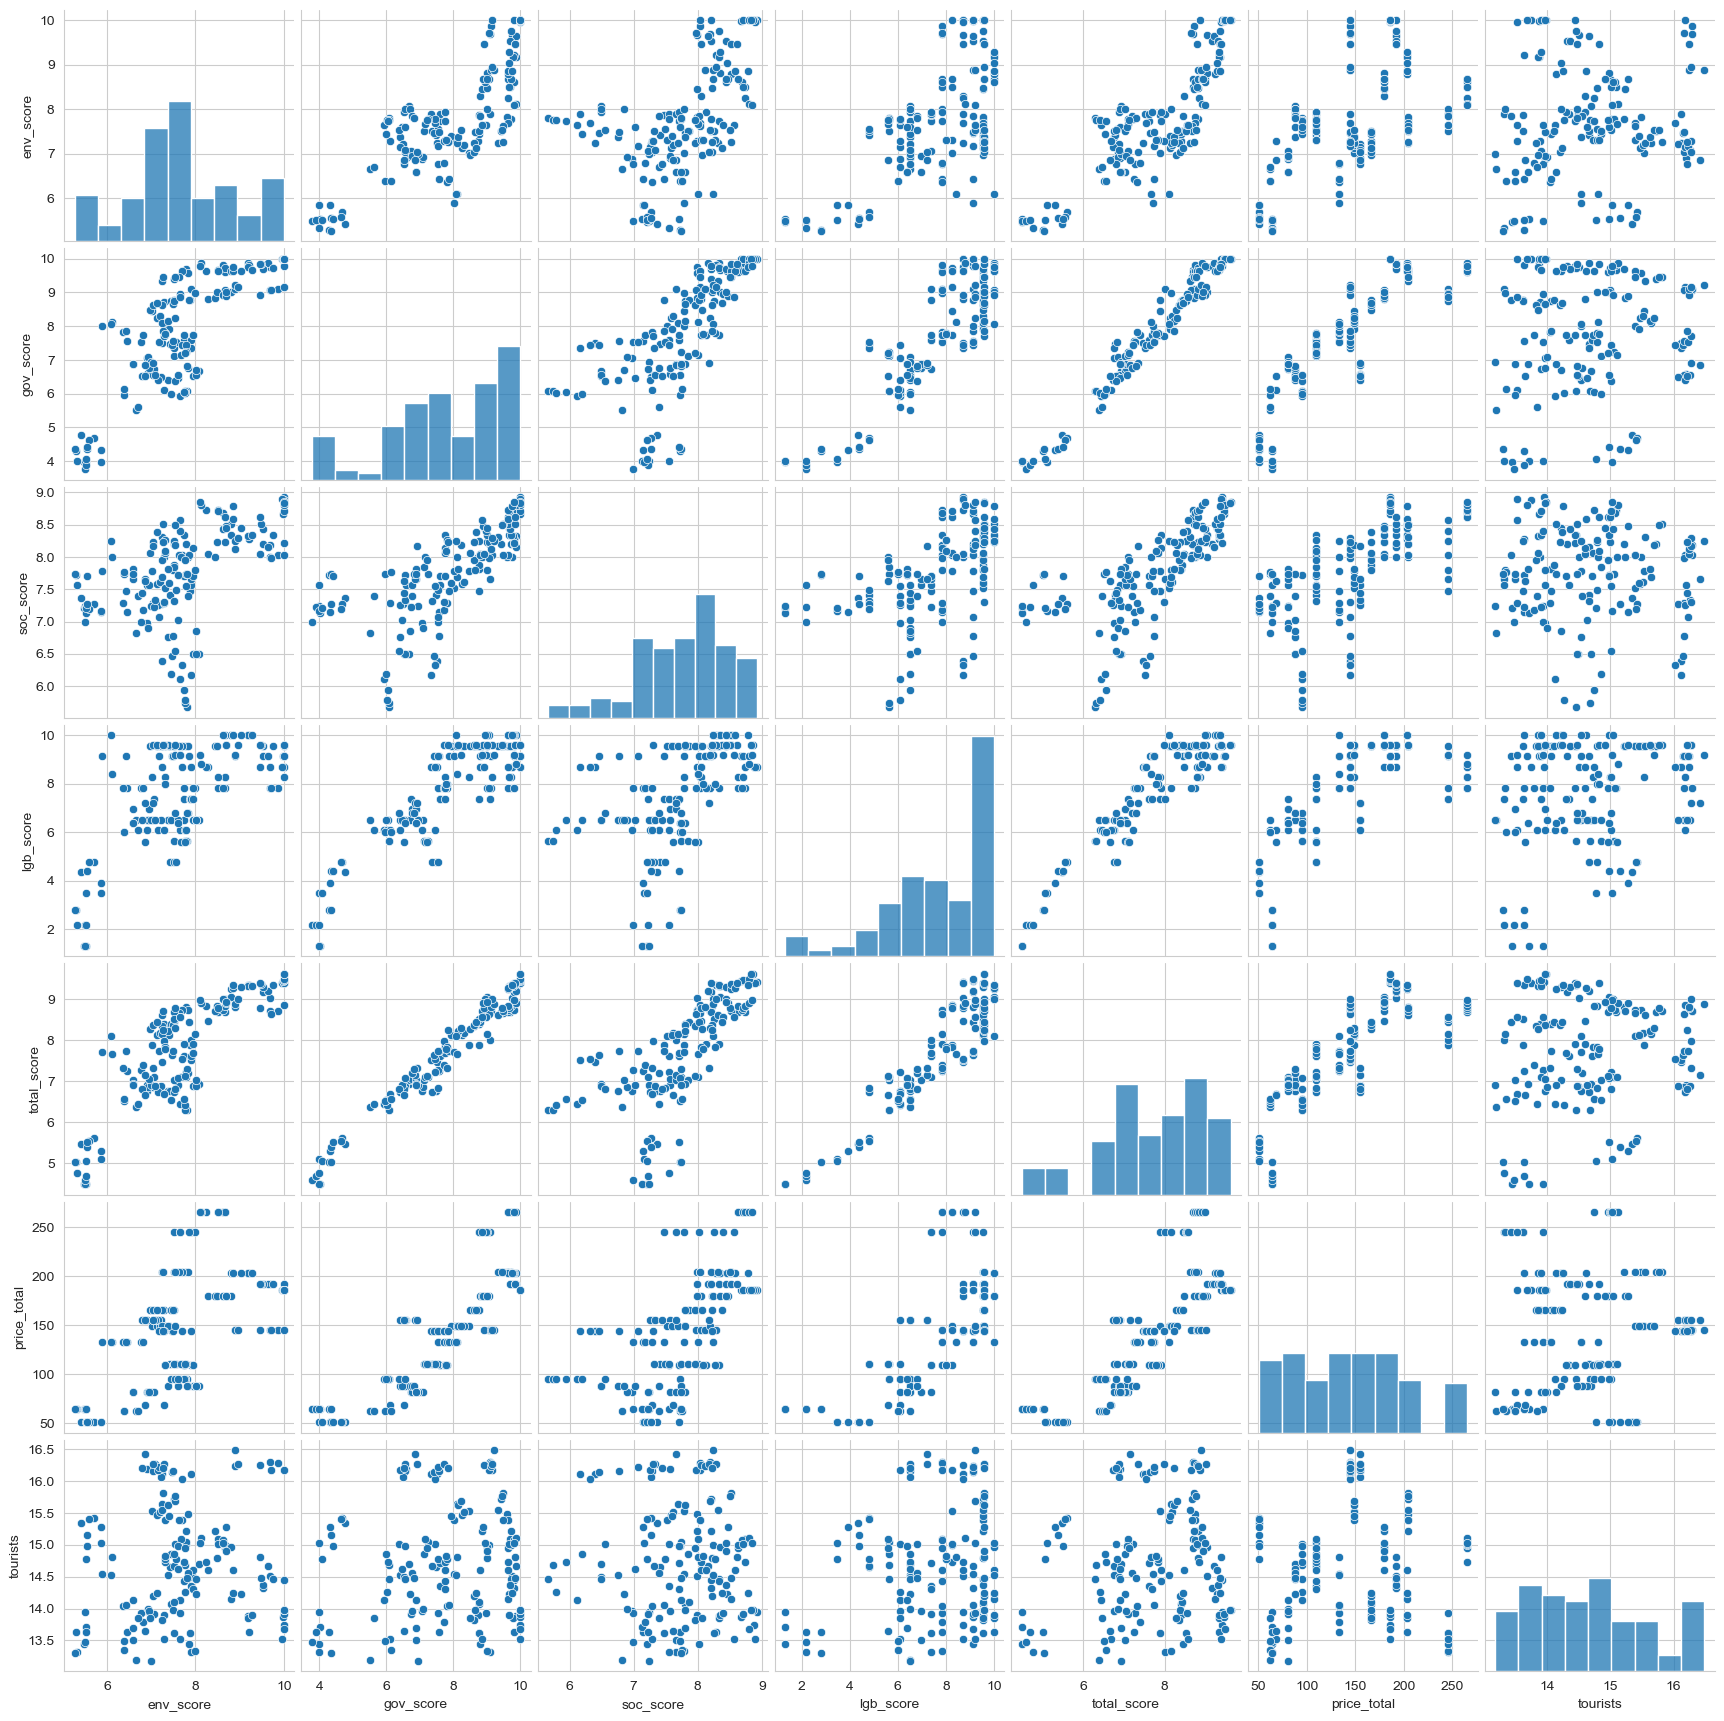

In [23]:
Xpair = df_log[['env_score', 'gov_score', 'soc_score', 'lgb_score', 'total_score', 'price_total', 'tourists']]
sns.pairplot(Xpair);

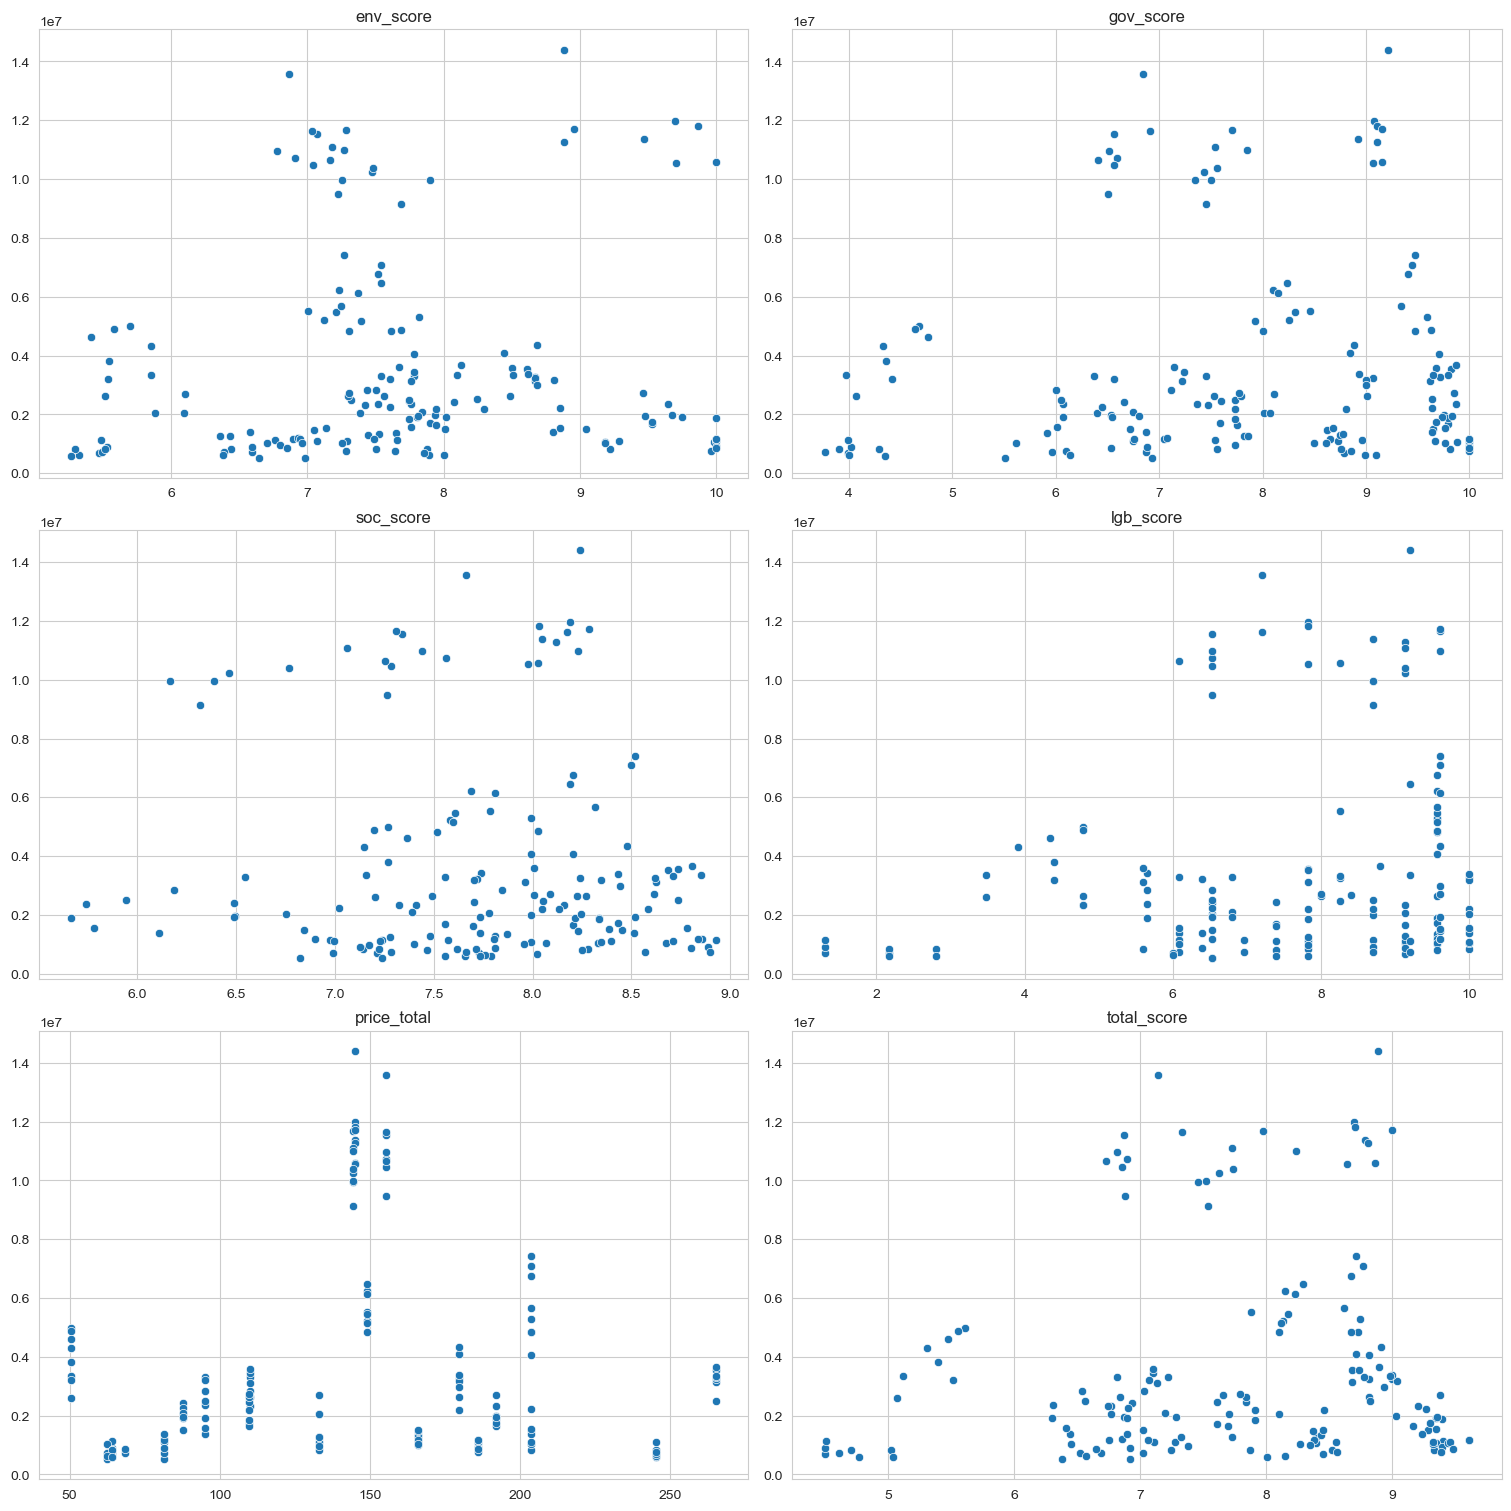

In [24]:
score_col = ['env_score', 'gov_score','soc_score', 'lgb_score', 'price_total', 'total_score']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in score_col:
    plt.subplot(rows, cols, counter)
    sns.scatterplot(data = df_analysis, x= i,y='tourists')
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

### Correlation Matrix and Heatmap

In [25]:
#rename the columns for the plots
df_log_plot = df_log.copy()
df_log_plot = df_log_plot.rename(columns={'env_score':'Environmental', 'gov_score':'Governmental', 'soc_score':'Social', 'lgb_score':'LGBTQ','total_score': 'Total ESG-Score', 'price_total': 'Price Level', 'tourists': 'Number of Tourists'})
df_log_plot.columns

Index(['iso3', 'year', 'Number of Tourists', 'Environmental', 'Governmental',
       'Social', 'LGBTQ', 'Price Level', 'Total ESG-Score'],
      dtype='object')

In [26]:
# df_analysis_plot = df_analysis.copy()
# df_analysis_plot = df_analysis_plot.rename(columns={'env_score':'Environmental', 'gov_score':'Governmental', 'soc_score':'Social', 'lgb_score':'LGBTQ','total_score': 'Total ESG-Score', 'price_total': 'Price Level', 'tourists': 'Number of Tourists'})
# df_analysis_plot.columns

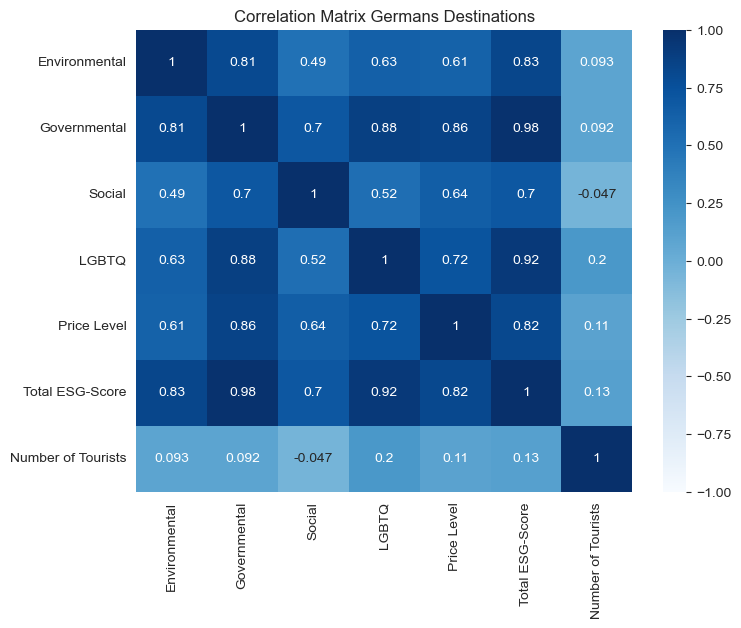

In [27]:
# Compute the correlation matrix
corr_matrix = df_log_plot[['Environmental', 'Governmental',
       'Social', 'LGBTQ', 'Price Level', 'Total ESG-Score', 'Number of Tourists']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Germans Destinations')
plt.show()

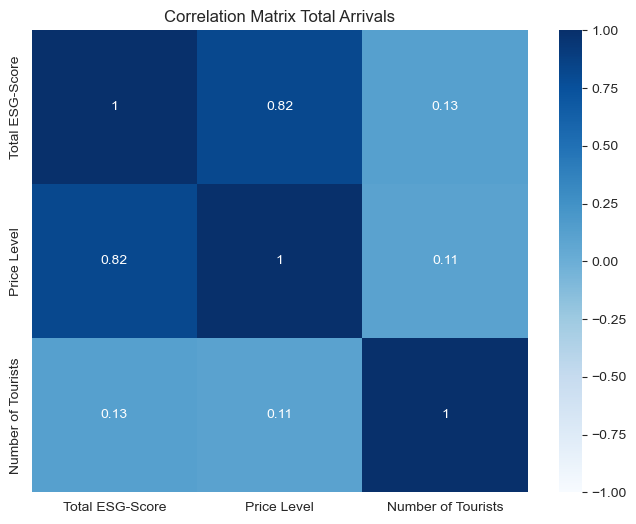

In [28]:
# Compute the correlation matrix
corr_matrix = df_log[['total_score', 'price_total', 'tourists']].corr()

# Rename the variables
corr_matrix = corr_matrix.rename(columns={'total_score': 'Total ESG-Score', 'price_total': 'Price Level', 'tourists': 'Number of Tourists'})

# Rename the rows (index)
corr_matrix = corr_matrix.rename(index={'total_score': 'Total ESG-Score', 'price_total': 'Price Level', 'tourists': 'Number of Tourists'})

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', vmin=-1, vmax=1)
plt.title('Correlation Matrix Total Arrivals')
plt.show()

The correlation coefficient of 0.11 suggests suggests a weak positive correlation between tourist numbers and Responsible Score.

### Simple linear regression

In [29]:
# Import the statsmodels module
import statsmodels.api as sm

In [30]:
# Prepare data for modeling
df_lin_reg = df_log.dropna()
# Choose the predictor X and add a constant term
X = df_lin_reg[['total_score']]
# Our model needs an intercept so we add a column of 1s:
X = sm.add_constant(X)
# Define dependent variable
y = df_lin_reg['tourists']

In [31]:
# Create an OLS model
model = sm.OLS(y, X)
# use the data to calculate the intercept and slope
results = model.fit()
# return the output of the model
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tourists   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.728
Date:                Mon, 10 Jul 2023   Prob (F-statistic):              0.101
Time:                        10:03:54   Log-Likelihood:                -211.68
No. Observations:                 165   AIC:                             427.4
Df Residuals:                     163   BIC:                             433.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.0246      0.421     33.306      0.000      13.193      14.856
total_score     0.0887      0.054      1.652      0.101      -0.017       0.195
==============================================================================
Omnibus:                       22.262   Durbin-Watson:                   2.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.771
Skew:                           0.323   Prob(JB):                       0.0125
Kurtosis:                       2.073   Cond. No.                         49.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Change over Years

### Create a DataFrame with the differenz from 2012 to 2019

In [32]:
change_years = ['2012-01-01',
                '2019-01-01']

# Filter the DataFrame based on the selected years
df_analysis_change = df_analysis[df_analysis['year'].isin(change_years)]

In [33]:
df_analysis

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total,total_score
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360,8.393951
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051,9.030803
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560,7.878286
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042,6.442761
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948,6.897282
...,...,...,...,...,...,...,...,...,...
174,CZE,2019-01-01,2728299.0,7.306397,7.770563,8.087819,8.000000,109.638014,7.791195
175,TUR,2019-01-01,3205210.0,5.538721,4.415584,7.705382,4.400000,50.562389,5.514922
176,HUN,2019-01-01,1385049.0,6.582492,6.872294,7.733711,6.400000,81.339403,6.897124
177,GBR,2019-01-01,2981999.0,8.686869,9.004329,8.441926,9.600000,179.763124,8.933281


In [34]:
# Create a copy of the DataFrame
df_percentage = df_analysis.copy()

# Calculate the sum of 'tourists' column
tourists_sum = df_percentage['tourists'].sum()

# Calculate the percentage for 'tourists' column
df_percentage['tourists_percentage'] = (df_percentage['tourists'] / tourists_sum) * 100

# Print the resulting DataFrame
df_percentage

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total,total_score,tourists_percentage
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360,8.393951,0.178647
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051,9.030803,0.328739
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560,7.878286,0.912545
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042,6.442761,0.226524
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948,6.897282,1.772726
...,...,...,...,...,...,...,...,...,...,...
174,CZE,2019-01-01,2728299.0,7.306397,7.770563,8.087819,8.000000,109.638014,7.791195,0.450551
175,TUR,2019-01-01,3205210.0,5.538721,4.415584,7.705382,4.400000,50.562389,5.514922,0.529308
176,HUN,2019-01-01,1385049.0,6.582492,6.872294,7.733711,6.400000,81.339403,6.897124,0.228727
177,GBR,2019-01-01,2981999.0,8.686869,9.004329,8.441926,9.600000,179.763124,8.933281,0.492447


In [35]:
df_percentage = df_percentage[df_percentage['iso3'] != 'rest_of_europe']


In [36]:
df_percentage

,iso3,year,tourists,env_score,gov_score,soc_score,lgb_score,price_total,total_score,tourists_percentage
0,BEL,2012-01-01,1081792.0,7.291667,8.724490,7.994429,9.565217,165.905360,8.393951,0.178647
1,DNK,2012-01-01,1990672.0,9.678030,9.755102,7.994429,8.695652,192.111051,9.030803,0.328739
2,FRA,2012-01-01,5525894.0,7.007576,8.459184,7.785515,8.260870,149.021560,7.878286,0.912545
3,GRC,2012-01-01,1371712.0,7.651515,5.918367,6.114206,6.086957,95.029042,6.442761,0.226524
4,ITA,2012-01-01,10734702.0,6.912879,6.591837,7.562674,6.521739,155.337948,6.897282,1.772726
...,...,...,...,...,...,...,...,...,...,...
173,ESP,2019-01-01,10984639.0,7.272727,7.846320,8.229462,9.600000,144.461584,8.237127,1.814000
174,CZE,2019-01-01,2728299.0,7.306397,7.770563,8.087819,8.000000,109.638014,7.791195,0.450551
175,TUR,2019-01-01,3205210.0,5.538721,4.415584,7.705382,4.400000,50.562389,5.514922,0.529308
176,HUN,2019-01-01,1385049.0,6.582492,6.872294,7.733711,6.400000,81.339403,6.897124,0.228727


In [37]:
change_years = ['2012-01-01',
                '2019-01-01']

# Filter the DataFrame based on the selected years
#df_analysis_change = df_analysis[df_analysis['year'].isin(change_years)]

df_analysis_change = df_percentage[df_percentage['year'].isin(change_years)]

In [38]:
#Create a new dataframe with the desired columns:
iso3_codes = df_analysis_change['iso3'].unique()
df_analysis_diff = pd.DataFrame(columns=['iso3', 'env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'tourists_diff'])


for iso3 in iso3_codes:
    iso3_rows = df_analysis_change[df_analysis_change['iso3'] == iso3]


    if len(iso3_rows) == 2:
        row_2012 = iso3_rows[iso3_rows['year'] == '2012-01-01']
        row_2019 = iso3_rows[iso3_rows['year'] == '2019-01-01']
        
        env_score_diff = row_2019['env_score'].values[0] - row_2012['env_score'].values[0]
        gov_score_diff = row_2019['gov_score'].values[0] - row_2012['gov_score'].values[0]
        soc_score_diff = row_2019['soc_score'].values[0] - row_2012['soc_score'].values[0]
        lgb_score_diff = row_2019['lgb_score'].values[0] - row_2012['lgb_score'].values[0]
        total_score_diff = row_2019['total_score'].values[0] - row_2012['total_score'].values[0]
        tourists_diff = row_2019['tourists_percentage'].values[0] - row_2012['tourists_percentage'].values[0]
        
        new_row = {'iso3': iso3, 'env_score_diff': env_score_diff, 'gov_score_diff': gov_score_diff,
                   'soc_score_diff': soc_score_diff, 'lgb_score_diff': lgb_score_diff, 'total_score_diff': total_score_diff, 'tourists_diff': tourists_diff}
        
    df_analysis_diff = df_analysis_diff.append(new_row, ignore_index=True)

In [39]:
df_analysis_diff

,iso3,env_score_diff,gov_score_diff,soc_score_diff,lgb_score_diff,total_score_diff,tourists_diff
0,BEL,-0.153620,-0.044836,0.390840,0.034783,0.056792,0.072952
1,DNK,-0.216751,0.093383,0.617469,0.904348,0.349612,0.119393
2,FRA,0.534512,-0.223253,0.401454,0.939130,0.412961,0.155522
3,GRC,-0.042088,0.640074,1.605341,0.313043,0.629093,0.303612
4,ITA,0.124158,0.323748,0.610130,0.678261,0.434074,0.148369
5,HRV,0.425084,0.409400,0.978836,0.278261,0.522895,-0.015914
6,NLD,-0.242003,-0.256030,0.295241,0.034783,-0.042002,0.499910
7,NOR,0.000000,0.000000,-0.089050,0.904348,0.203825,0.004996
8,AUT,-0.740741,0.074212,0.096704,1.773913,0.301022,-0.042217
9,POL,0.336700,-0.250773,0.550869,0.817391,0.363547,0.132817


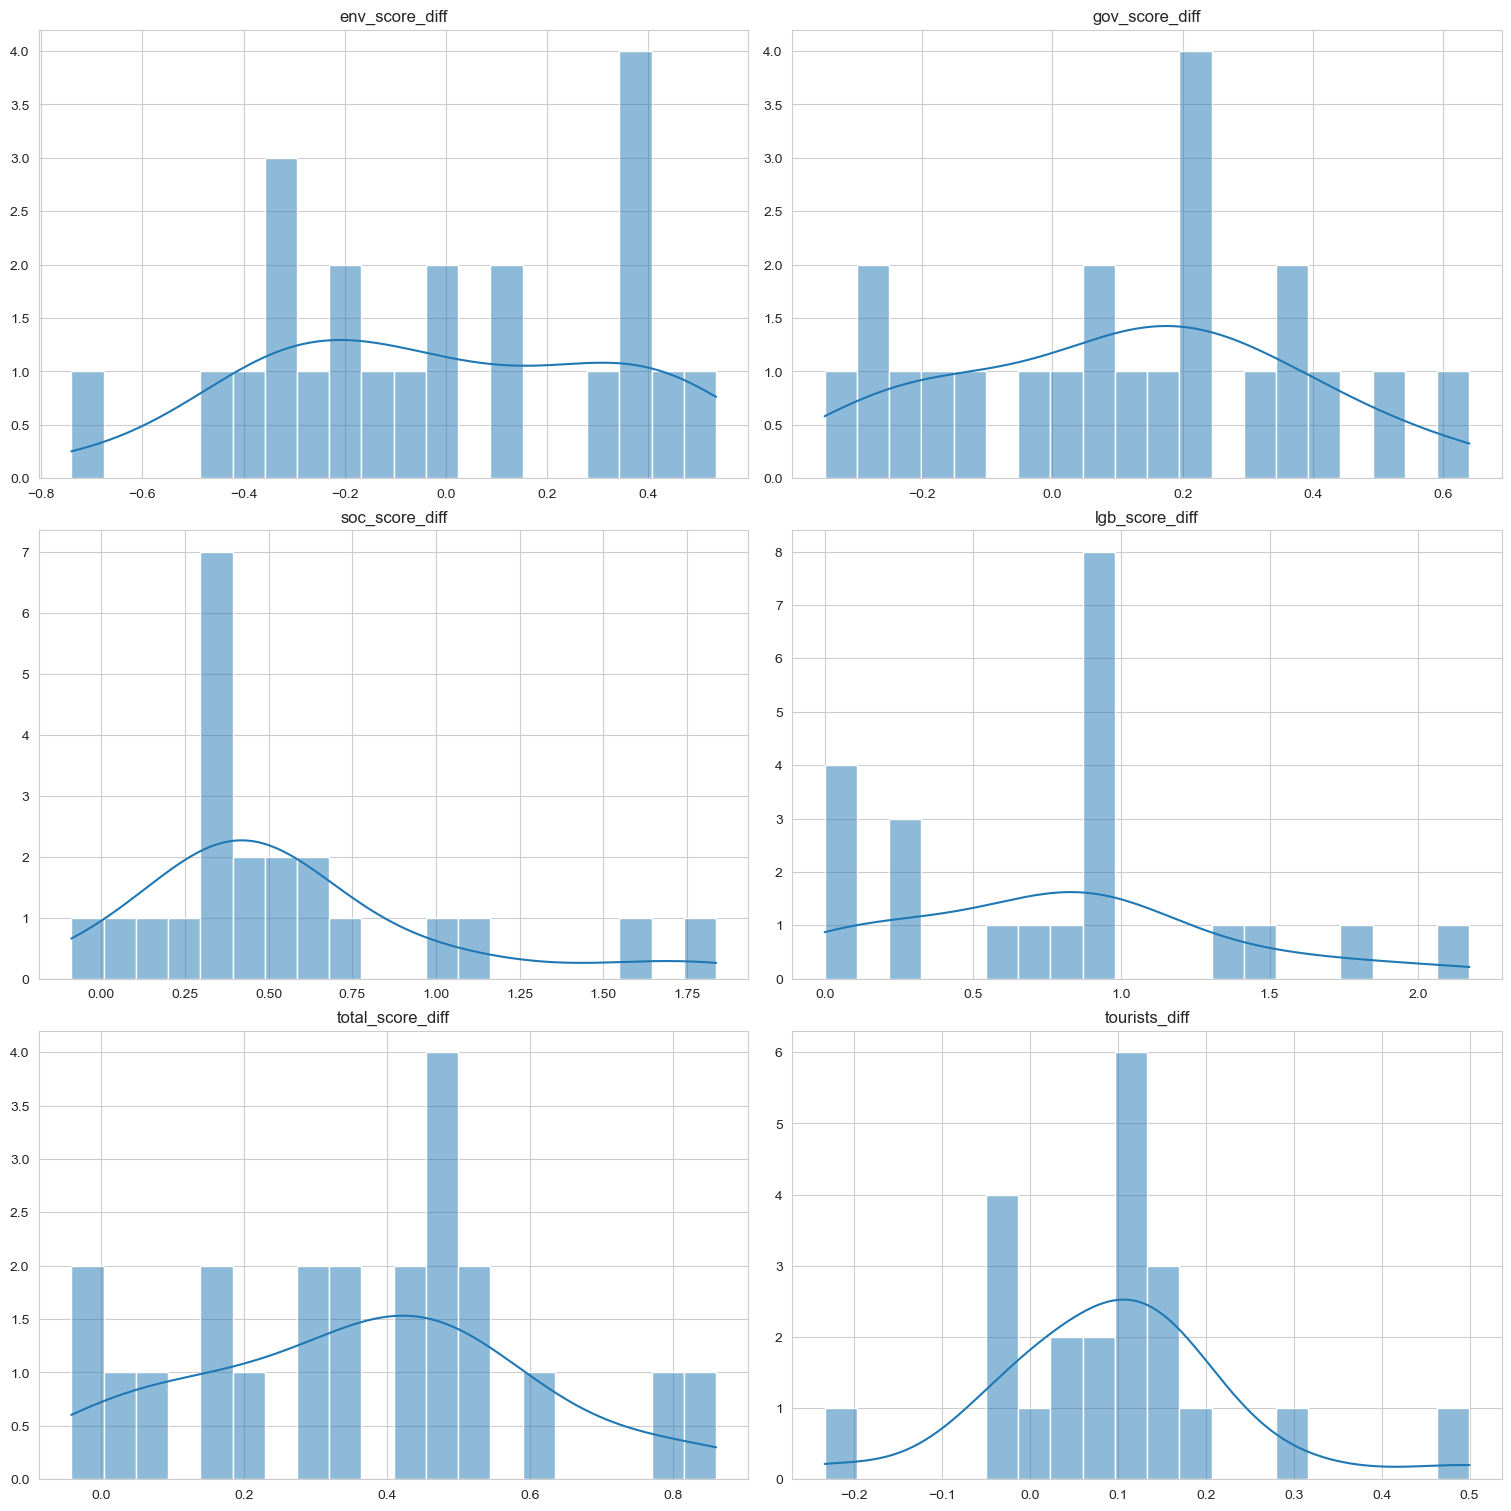

In [40]:
num_col = ['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'tourists_diff']
rows, cols = 3, 2
plt.figure(figsize=(15,15), constrained_layout = True )

counter = 1
for i in num_col:
    plt.subplot(rows, cols, counter)
    sns.histplot(data =df_analysis_diff, x= i, bins=20, kde=True)
    plt.title(i)
    plt.xlabel("")
    plt.ylabel("")
    counter+=1

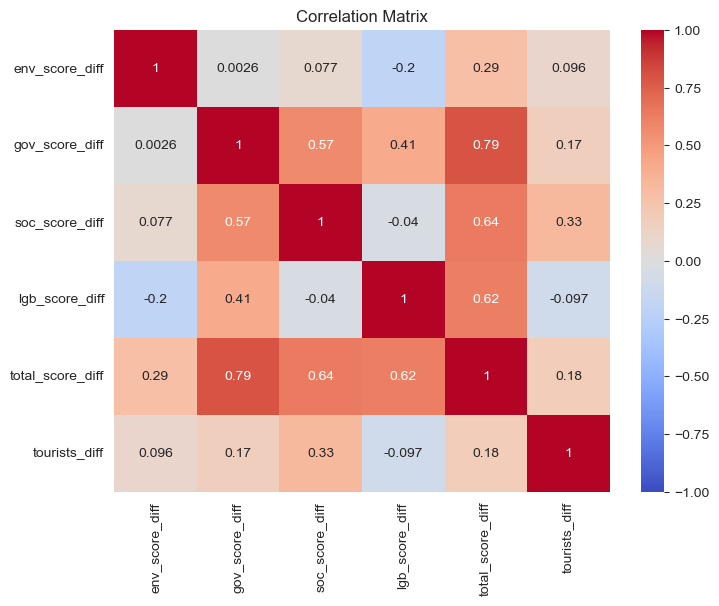

In [41]:
# Compute the correlation matrix
corr_matrix_diff = df_analysis_diff[['env_score_diff', 'gov_score_diff', 'soc_score_diff', 'lgb_score_diff', 'total_score_diff', 'tourists_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

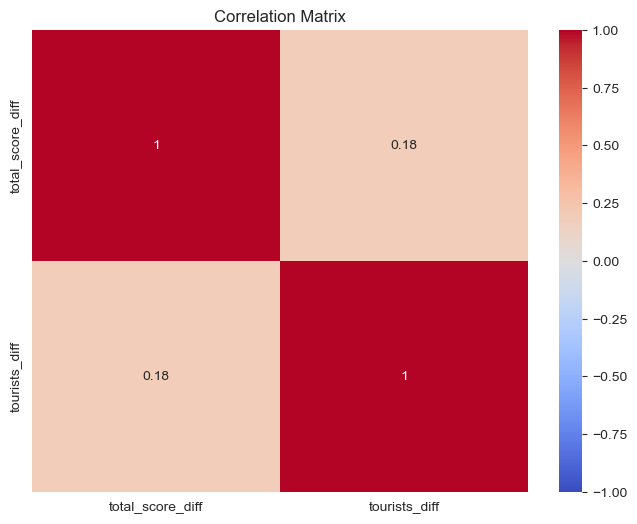

In [42]:
# Compute the correlation matrix
corr_matrix_diff = df_analysis_diff[['total_score_diff', 'tourists_diff']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()